In [3]:
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [2]:
# load raw data and transform to be well-formed
def parse_ymdh_to_datetime(x):
 return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv',parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse_ymdh_to_datetime)
dataset.drop('No', axis=1, inplace=True)
print(dataset.info())

#change column by possition
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
print(dataset.info())
dataset.to_csv('pollution.csv')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pm2.5   41757 non-null  float64
 1   DEWP    43824 non-null  int64  
 2   TEMP    43824 non-null  float64
 3   PRES    43824 non-null  float64
 4   cbwd    43824 non-null  object 
 5   Iws     43824 non-null  float64
 6   Is      43824 non-null  int64  
 7   Ir      43824 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB
None
                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      

In [227]:
dataset = pd.read_csv('pollution.csv', header=0, index_col=0)
print(f"wnd_dir : {dataset['wnd_dir'].unique()}")
print(dataset.head())



wnd_dir : ['SE' 'cv' 'NW' 'NE']
                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


# Get Values

In [228]:
values = dataset.values
# integer encode direction

# encode wnd_dir : ['SE' 'cv' 'NW' 'NE']
encoder = LabelEncoder() 
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float

values = values.astype('float32')
print(values[:3])

[[ 129.    -16.     -4.   1020.      2.      1.79    0.      0.  ]
 [ 148.    -15.     -4.   1020.      2.      2.68    0.      0.  ]
 [ 159.    -11.     -5.   1021.      2.      3.57    0.      0.  ]]


In [229]:
#dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain']
groups = [0, 1, 2, 3,4, 5, 6, 7]

# plot each column
def plot_all_data(x_values):
    pyplot.figure(figsize=(8,12))
    i = 1 # for set chart on gifure
    for group in groups:
      pyplot.subplot(len(groups), 1, i)

      if group!=4:
       pyplot.plot(x_values[:, group])
      else:
       pyplot.hist(x_values[:, group],bins=4)  
      pyplot.title(dataset.columns[group], y=0.5, loc='right')
      i += 1
    pyplot.show()
    


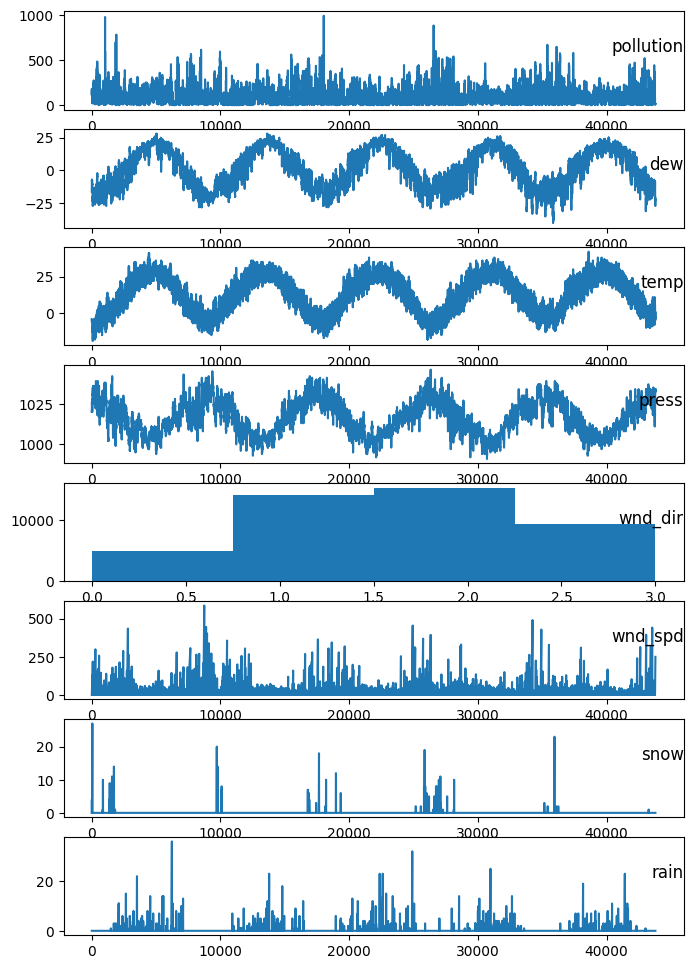

In [230]:
plot_all_data(values)


# Feature eng Normalize


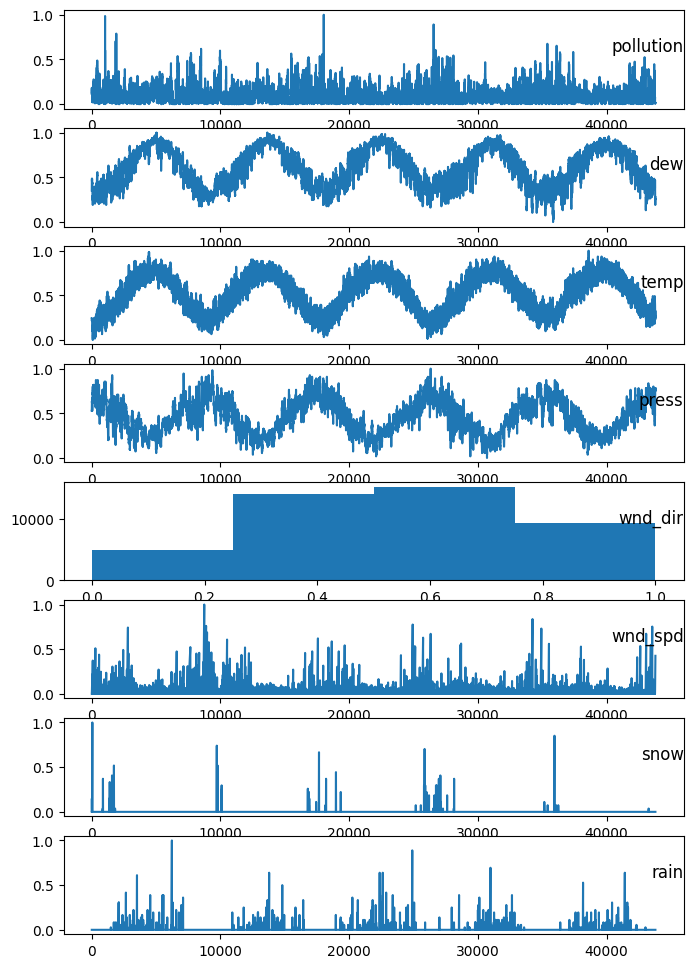

In [231]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)
scaled_values=np.around(scaled_values,decimals=6)

plot_all_data(scaled_values)

# Multivariate LSTM Forecast Model


In [232]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [233]:
print(scaled_values[:3])

[[0.129779 0.352941 0.245902 0.527273 0.666667 0.00229  0.       0.      ]
 [0.148893 0.367647 0.245902 0.527273 0.666667 0.003811 0.       0.      ]
 [0.15996  0.426471 0.229508 0.545454 0.666667 0.005332 0.       0.      ]]


In [234]:
# frame as supervised learning
reframed = series_to_supervised(scaled_values,1 , 1)
print(reframed.info())
print(reframed.head(3))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43799 entries, 1 to 43799
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   var1(t-1)  43799 non-null  float32
 1   var2(t-1)  43799 non-null  float32
 2   var3(t-1)  43799 non-null  float32
 3   var4(t-1)  43799 non-null  float32
 4   var5(t-1)  43799 non-null  float32
 5   var6(t-1)  43799 non-null  float32
 6   var7(t-1)  43799 non-null  float32
 7   var8(t-1)  43799 non-null  float32
 8   var1(t)    43799 non-null  float32
 9   var2(t)    43799 non-null  float32
 10  var3(t)    43799 non-null  float32
 11  var4(t)    43799 non-null  float32
 12  var5(t)    43799 non-null  float32
 13  var6(t)    43799 non-null  float32
 14  var7(t)    43799 non-null  float32
 15  var8(t)    43799 non-null  float32
dtypes: float32(16)
memory usage: 3.0 MB
None
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.6666

In [235]:
# drop columns since var2(t), keep only var1(t)  as predict value
cols_drop=['var2(t)',   'var3(t)',   'var4(t)',   'var5(t)',   'var6(t)' ,  'var7(t)', 'var8(t)']
reframed.drop(columns=cols_drop, axis=1, inplace=True)
reframed.head(3)


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.0,0.0,0.148893
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.0,0.0,0.159960
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.0,0.0,0.182093


In [236]:
...
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]


In [237]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 8) (8760,) (35039, 8) (35039,)


In [238]:
# reshape input to be 3D [samples, timesteps to train (we just look at next hour var1(t)), features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


# Define and Fit Model

In [239]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [240]:

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network


Epoch 1/30
122/122 - 4s - loss: 0.0575 - val_loss: 0.0506 - 4s/epoch - 35ms/step
Epoch 2/30
122/122 - 1s - loss: 0.0369 - val_loss: 0.0507 - 1s/epoch - 9ms/step
Epoch 3/30
122/122 - 1s - loss: 0.0209 - val_loss: 0.0412 - 1s/epoch - 10ms/step
Epoch 4/30
122/122 - 1s - loss: 0.0165 - val_loss: 0.0307 - 1s/epoch - 10ms/step
Epoch 5/30
122/122 - 1s - loss: 0.0153 - val_loss: 0.0201 - 1s/epoch - 11ms/step
Epoch 6/30
122/122 - 1s - loss: 0.0149 - val_loss: 0.0171 - 1s/epoch - 12ms/step
Epoch 7/30
122/122 - 2s - loss: 0.0148 - val_loss: 0.0161 - 2s/epoch - 13ms/step
Epoch 8/30
122/122 - 1s - loss: 0.0148 - val_loss: 0.0155 - 1s/epoch - 12ms/step
Epoch 9/30
122/122 - 1s - loss: 0.0146 - val_loss: 0.0151 - 1s/epoch - 12ms/step
Epoch 10/30
122/122 - 1s - loss: 0.0147 - val_loss: 0.0149 - 1s/epoch - 11ms/step
Epoch 11/30
122/122 - 1s - loss: 0.0147 - val_loss: 0.0149 - 1s/epoch - 10ms/step
Epoch 12/30
122/122 - 1s - loss: 0.0147 - val_loss: 0.0146 - 1s/epoch - 10ms/step
Epoch 13/30
122/122 - 1s -

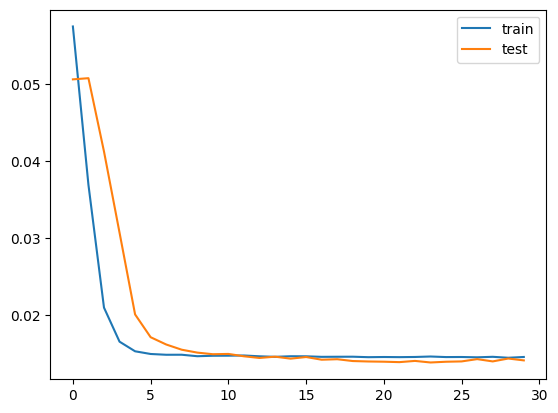

In [241]:
history = model.fit(train_X, train_y, epochs=30, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Evaluate Model

In [204]:
...
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


1095/1095 [==============================] - 3s 2ms/step


In [214]:
# invert scaling for forecast 
# test_X[:, 1:]  exclude 0 , it is PredictValue
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_yhat

array([34.55216 , 30.3184  , 20.114279, ...,  9.624261,  9.637254,
        7.982973], dtype=float32)

In [217]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


In [219]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.625
